In [ ]:
##!pip install --upgrade --no-cache-dir gdown
##!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
# use the other file ids if the first one doesn't work
#!gdown  --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
#!gdown --id 1RwjzPz-MJ5m2bhStVIDUS9l9jfwQ-sSW
##!unzip -q landscapes.zip -d ./data_colorization

/home/tico/anaconda3/envs/DDPG_env/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
From (redirected): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0&confirm=t&uuid=cab74c7f-5353-43de-bcc7-f48ada0099f4
To: /home/tico/Desktop/master_research/fabian_research/stable_diffusion_cr/sd/landscapes.zip
100%|████████████████████████████████████████| 650M/650M [00:07<00:00, 85.4MB/s]


In [1]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import numpy as np

class PineappleDataset(Dataset):
    def __init__(self, train=True, train_ratio=0.8):
        # Get all images sorted from the specified folder.
        self.all_images = sorted(glob.glob("./FULL_VERTICAL_PINEAPPLE/FULL_UNIFIED/*"))
        # Calculate the index at which to split the dataset.
        split_index = int(len(self.all_images) * train_ratio)
        # Partition the images based on the 'train' flag.
        if train:
            self.images = self.all_images[:split_index]
        else:
            self.images = self.all_images[split_index:]
        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        channels = 3
        # Resize the image.
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        # Convert to float32 and normalize.
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        # Rearrange the dimensions to (channels, height, width).
        image = np.transpose(image, (2, 0, 1))
        return image

    def __getitem__(self, idx):
        image = self.transform_image(self.images[idx])
        sample = {'image': image, 'idx': idx}
        return sample

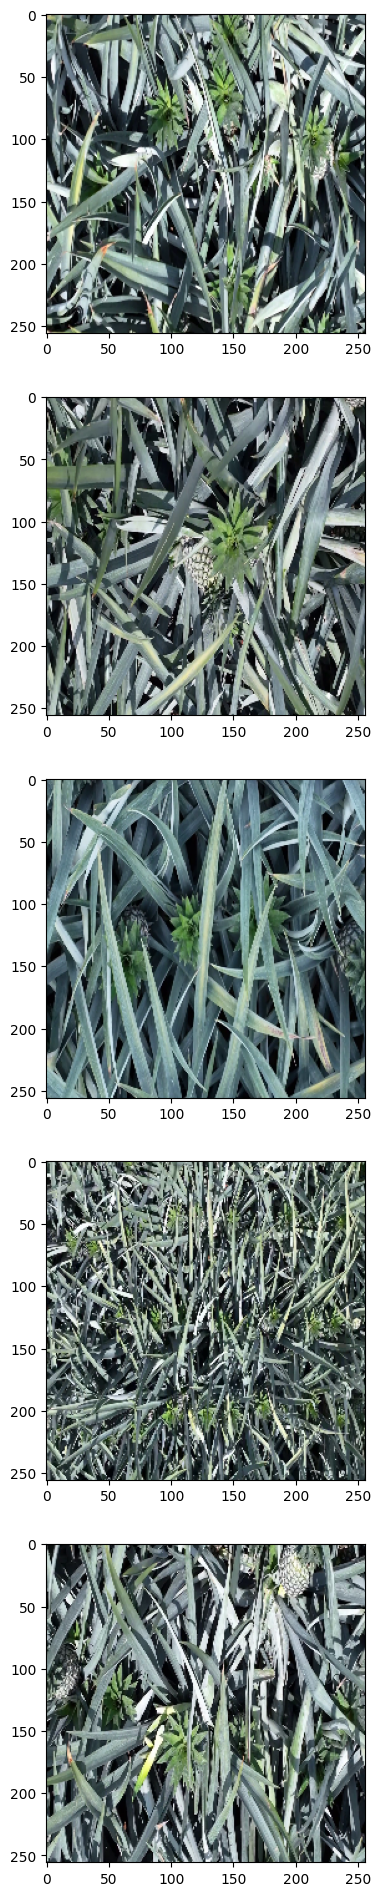

In [2]:
import matplotlib.pyplot as plt
trainset = PineappleDataset(train=True, train_ratio=0.8)
#trainset = CustomCIFARDataset(train=True, train_ratio=0.8)

fig=plt.figure(figsize=(24, 24))
columns = 1
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
plt.show()

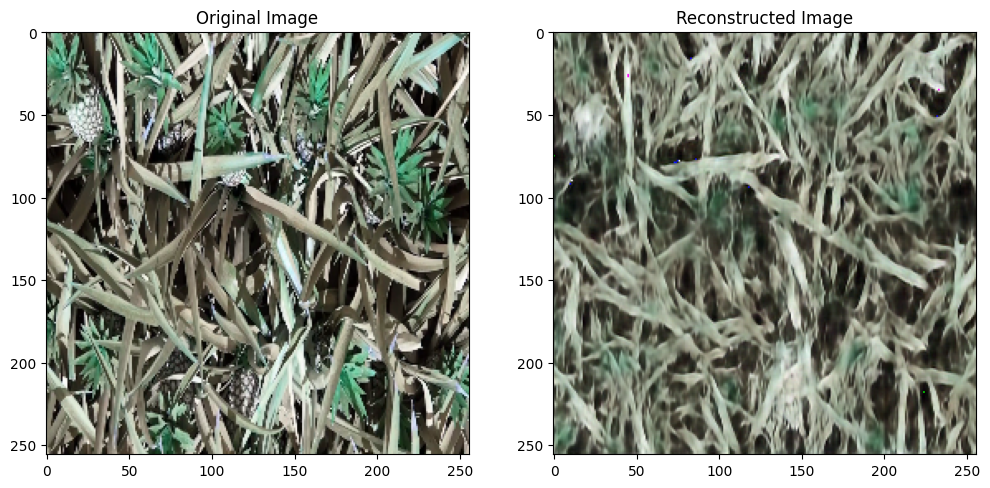

In [41]:
import torch
import numpy as np
import cv2
from VAE import VAE  # Make sure VAE is correctly imported from your VAE.py

# 1. Load the trained VAE checkpoint
model = VAE()
checkpoint_path = "./checkpoints/weights_ck_49.pt"  # Replace with your checkpoint file
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()
model.cuda()  # Move model to GPU if available

test_set = PineappleDataset(train=False, train_ratio=0.8)
# 2. Load the test image
test_image = test_set[0]['image']
test_image = torch.tensor(test_image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU
# 3. Pass the image through the model
with torch.no_grad():
    reconstructed_image, _, _ = model(test_image)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  # Change to HWC format
    reconstructed_image = (reconstructed_image * 255).astype(np.uint8)  # Convert to uint8
# 4. Display the original and reconstructed images
fig = plt.figure(figsize=(12, 6))
columns = 2
rows = 1
original_image = test_set[0]['image'].transpose((1, 2, 0))
original_image = (original_image * 255).astype(np.uint8)  # Convert to uint8
# add labels to the images
fig.add_subplot(rows, columns, 1, title='Original Image')
plt.imshow(original_image)
fig.add_subplot(rows, columns, 2, title='Reconstructed Image')
plt.imshow(reconstructed_image)
plt.show()


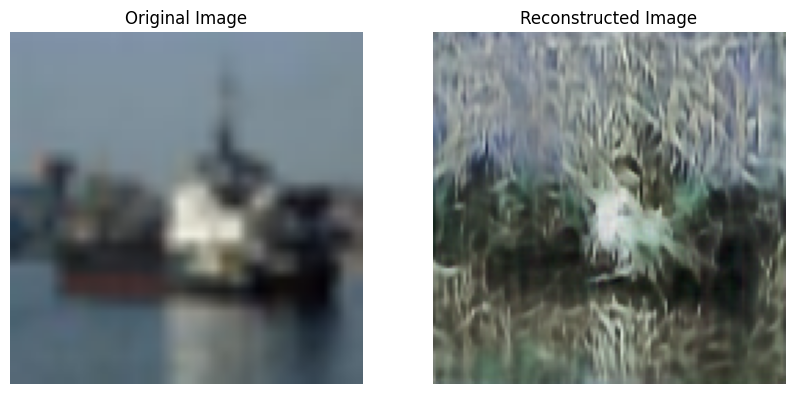

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from VAE import VAE  # Make sure VAE is defined correctly
from torchvision import datasets, transforms

# Define CIFAR-compatible dataset
class CustomCIFARDataset(torch.utils.data.Dataset):
    def __init__(self, train=True, train_ratio=0.8):
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),  # [C, H, W] and normalized to [0, 1]
        ])
        full_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
        split_index = int(len(full_dataset) * train_ratio)
        if train:
            self.data = full_dataset.data[:split_index]
            self.targets = full_dataset.targets[:split_index]
        else:
            self.data = full_dataset.data[split_index:]
            self.targets = full_dataset.targets[split_index:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        image = transforms.ToPILImage()(image)
        image = self.transform(image)
        return {'image': image, 'label': label, 'idx': idx}

# 1. Load the trained VAE checkpoint
model = VAE()
checkpoint_path = "./checkpoints/weights_ck_49.pt"  # Replace with your checkpoint path
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Load CIFAR test sample
test_set = CustomCIFARDataset(train=False, train_ratio=0.8)
test_sample = test_set[1]
test_image = test_sample['image'].unsqueeze(0).to(device)  # Add batch dimension

# 3. Forward pass through the model
with torch.no_grad():
    reconstructed_image, _, _ = model(test_image)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()
    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  # [H, W, C]
    reconstructed_image = (reconstructed_image * 255).astype(np.uint8)

# 4. Original image
original_image = test_sample['image'].cpu().numpy()
original_image = np.transpose(original_image, (1, 2, 0))  # [H, W, C]
original_image = (original_image * 255).astype(np.uint8)

# 5. Display original vs reconstructed image
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1, title='Original Image')
plt.imshow(original_image)
plt.axis('off')
fig.add_subplot(1, 2, 2, title='Reconstructed Image')
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [48]:
import torch

# Example: Create a random latent vector from the encoder's output (e.g., (Batch_Size, 4, Height / 8, Width / 8))
batch_size = 8
height, width = 128, 128
latent = torch.randn(batch_size, 4, height // 8, width // 8).cuda()  # Random tensor representing the latent space

# Initialize the VAE decoder
decoder = model.decoder

# Pass the latent vector through the decoder to get the reconstructed image
reconstructed_image = decoder(latent)

print(f"Reconstructed image shape: {reconstructed_image.shape}")

Reconstructed image shape: torch.Size([8, 3, 128, 128])


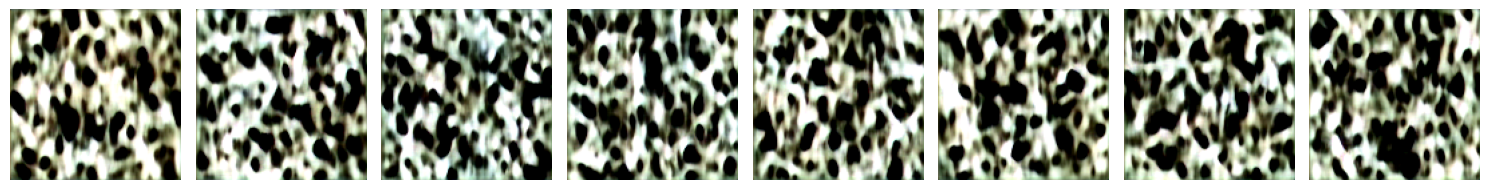

In [49]:
import matplotlib.pyplot as plt
import torch

# Your code
batch_size = 8
height, width = 128, 128
latent = torch.randn(batch_size, 4, height // 8, width // 8).cuda()

decoder = model.decoder
reconstructed_image = decoder(latent)

# Move tensor to CPU and clamp values (for visualization)
reconstructed_image = reconstructed_image.detach().cpu().clamp(0, 1)

# Plot the images
n_images = min(batch_size, 8)  # Plot up to 8 images
fig, axes = plt.subplots(1, n_images, figsize=(15, 3))
for i in range(n_images):
    img = reconstructed_image[i].permute(1, 2, 0)  # CHW -> HWC
    axes[i].imshow(img)
    axes[i].axis("off")
plt.tight_layout()
plt.show()
